In [101]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [116]:
# Load and preprocess the data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['timestamp'])
    df.set_index('timestamp', inplace=True)

    # Add some time features
    # df['hour'] = df.index.hour
    # df['day_of_week'] = df.index.dayofweek
    # df['month'] = df.index.month
    return df

,load_mg1_1,load_mg1_2,load_mg1_3,load_mg1_4,load_mg1_5,load_mg1_6,load_mg1_7,load_mg1_8,load_mg1_9,load_mg1_10,...,load_mg1_25,load_mg1_26,load_mg1_27,load_mg1_28,load_mg1_29,load_mg1_30,load_mg1_31,hour,day_of_week,month
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,0.968002,0.118,0.104000,0.154,0.604001,0.130,0.480002,0.086,0.186,0.686003,...,0.328002,0.230001,0.342,0.306001,1.220004,0.144000,0.148001,0,4,1
2021-01-01 00:30:00,0.794000,0.094,0.094000,0.140,0.656001,0.122,0.374000,0.090,0.122,0.640001,...,0.350001,0.206001,0.382,0.148000,0.416002,0.052000,0.190000,0,4,1
2021-01-01 01:00:00,0.614000,0.118,0.333999,0.138,0.316000,0.158,0.476001,0.188,0.140,0.388001,...,0.104001,0.255999,0.094,0.262001,0.595997,0.175999,0.362002,1,4,1
2021-01-01 01:30:00,0.428000,0.098,0.334000,0.112,0.204000,0.150,0.446000,0.206,0.144,0.322000,...,0.106000,0.268000,0.092,0.144000,0.502001,0.156000,0.408001,1,4,1
2021-01-01 02:00:00,0.698000,0.104,0.278001,0.114,0.222000,0.130,0.364000,0.186,0.154,0.382000,...,0.104000,0.176000,0.094,0.152000,0.502000,0.264001,0.400000,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-05 01:30:00,0.308000,0.094,0.434000,0.136,0.604001,0.140,0.500000,0.156,0.120,0.304000,...,0.100000,0.142001,0.136,0.156000,0.782003,0.288000,0.546000,1,1,1
2021-01-05 02:00:00,0.250000,0.092,0.494000,0.106,0.492000,0.158,0.716001,0.144,0.174,0.294000,...,0.100000,0.108000,0.080,0.248000,1.347997,0.274000,0.320000,2,1,1
2021-01-05 02:30:00,0.138000,0.092,0.104000,0.108,0.470001,0.144,0.494000,0.084,0.090,0.340000,...,0.096000,0.112000,0.084,0.230000,0.426002,0.231999,0.170000,2,1,1


In [103]:
# Create sequences for LSTM input
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

In [104]:
# Build the LSTM model
def build_model(input_shape, output_shape):
    model = keras.models.Sequential([
        keras.layers.LSTM(100, activation='relu', input_shape=input_shape, return_sequences=True),
        keras.layers.LSTM(100, activation='relu'),
        keras.layers.Dense(output_shape)  # output units for 31 residents
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [105]:
# Evaluate the model
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")

In [106]:
# Load and preprocess the data
df = load_and_preprocess_data('data/customer_power_data.csv')
df_reactive = load_and_preprocess_data('data/customer_reactive_power_data.csv')

# Prepare the data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_data_reactive = scaler.fit_transform(df_reactive)

# Create sequences
sequence_length = 1  # Use 0.5 hours of data to predict the next hour
X, y = create_sequences(scaled_data, sequence_length)

# Build and train the model
model = build_model((X.shape[1], X.shape[2]), df.shape[1])
history = model.fit(X, y, epochs=100, batch_size=32, verbose=1)

# Make predictions
predictions = model.predict(X)

# Evaluate the model
evaluate_model(y, predictions)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y = scaler.inverse_transform(y)

Epoch 1/100


c:\Users\cxlan\Source\Repos\FEIT-Hackathon-2024\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0093
Epoch 2/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0052
Epoch 3/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0047
Epoch 4/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0046
Epoch 5/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0044
Epoch 6/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0044
Epoch 7/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0043
Epoch 8/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0043
Epoch 9/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0043
Epoch 10/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0043
Epoch 11/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0043
Epoch 12/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0043
Epoch 13/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0043
Epoch 14/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0042
Epoch 15/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

In [107]:
# Save the model
model.save('model.h5')

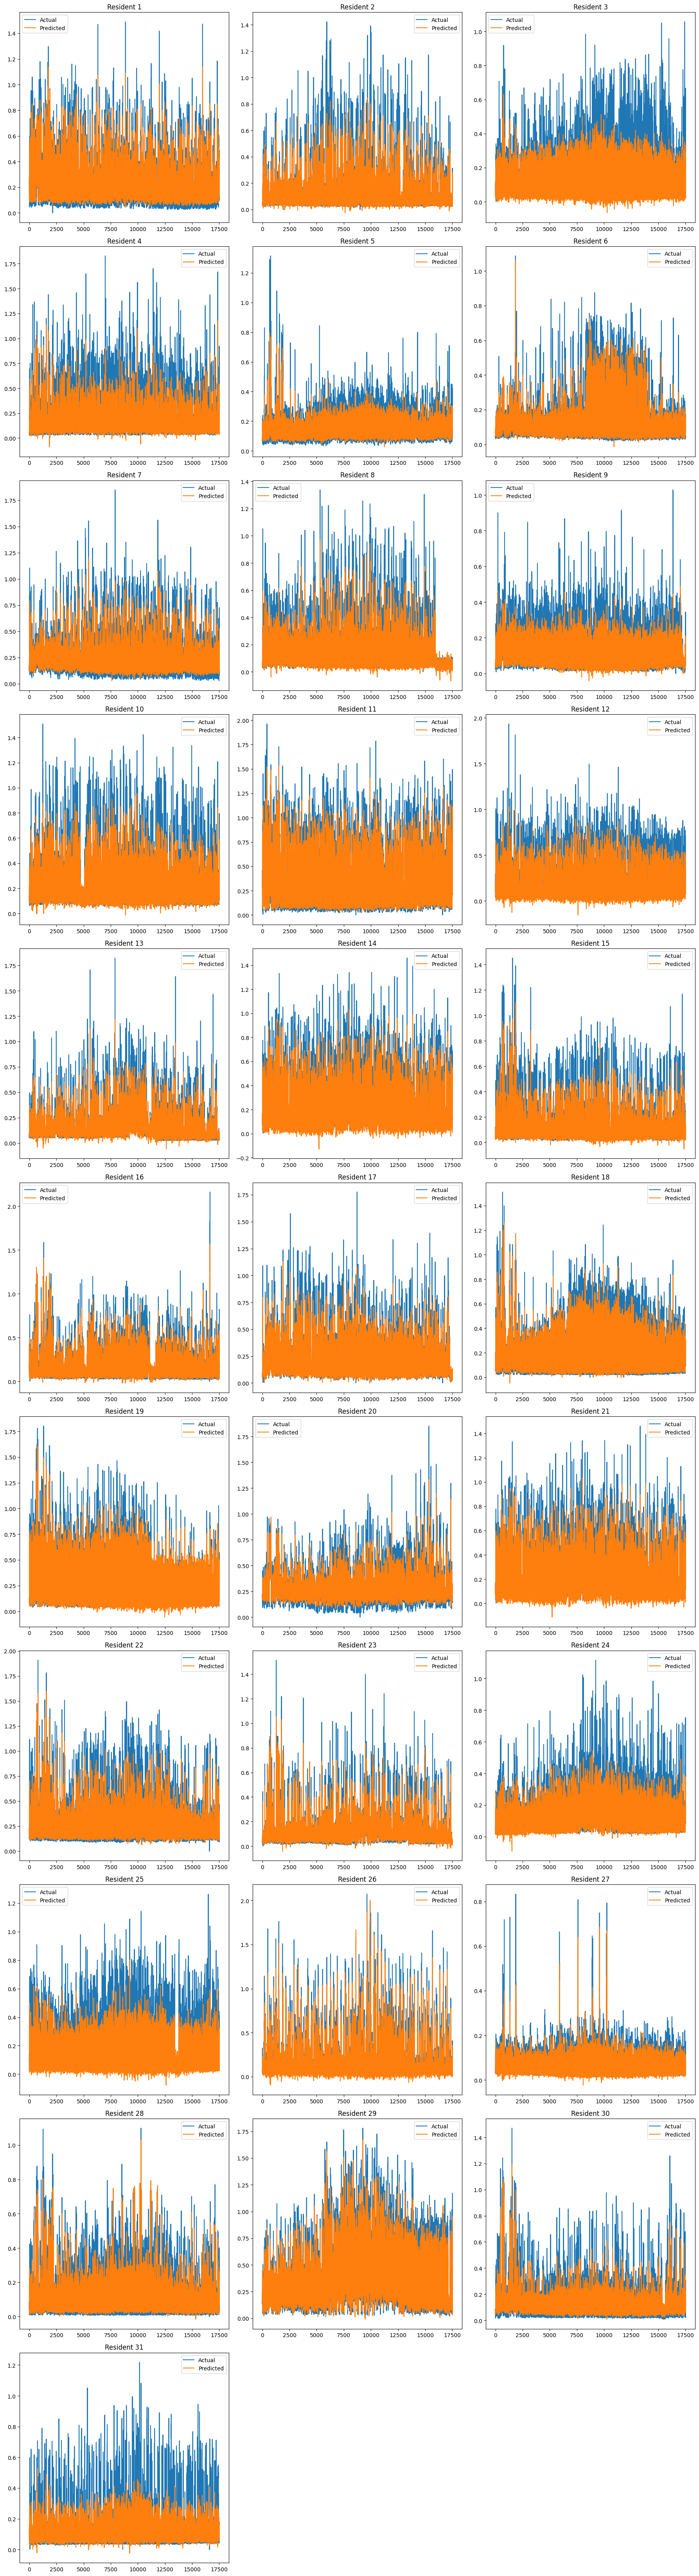

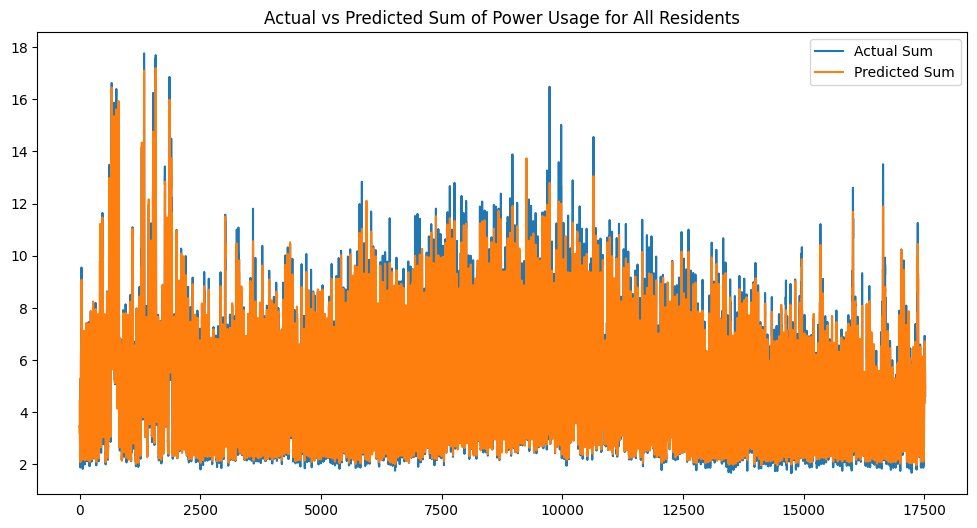

In [108]:
# Plot the results for all residents
num_residents = y.shape[1]
residents_per_row = 3
num_rows = (num_residents + residents_per_row - 1) // residents_per_row

plt.figure(figsize=(18, 6 * num_rows))
for i in range(num_residents):
    if i == 31:    # No need to draw year, month and day
        break
    plt.subplot(num_rows, residents_per_row, i + 1)
    plt.plot(y[:, i], label='Actual')
    plt.plot(predictions[:, i], label='Predicted')
    plt.legend()
    plt.title(f'Resident {i+1}')
plt.tight_layout()
plt.show()

# Calculate and print the sum of predictions for all residents
sum_predictions = np.sum(predictions, axis=1)
sum_actual = np.sum(y, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(sum_actual, label='Actual Sum')
plt.plot(sum_predictions, label='Predicted Sum')
plt.legend()
plt.title('Actual vs Predicted Sum of Power Usage for All Residents')
plt.show()